# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [123]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas_profiling as pp
from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')

# Load data

In [124]:
vehicles = pd.read_csv('data/vehicles.csv')
vehicles.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [125]:
orig_rows, orig_cols = vehicles.shape
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [126]:
vehicles.describe(include='all')

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
count,4.268800e+05,426880,4.268800e+05,425675.000000,409234,421603,252776,249202,423867,4.224800e+05,418638,424324,265838,296313,120519,334022,296677,426880
unique,NaN,404,NaN,NaN,42,29649,6,8,5,NaN,6,3,118246,3,4,13,12,51
top,NaN,columbus,NaN,NaN,ford,f-150,good,6 cylinders,gas,NaN,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,NaN,3608,NaN,NaN,70985,8009,121456,94169,356209,NaN,405117,336524,261,131904,63465,87056,79285,50614
mean,7.311487e+09,NaN,7.519903e+04,2011.235191,NaN,NaN,NaN,NaN,NaN,9.804333e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.473170e+06,NaN,1.218228e+07,9.452120,NaN,NaN,NaN,NaN,NaN,2.138815e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,7.207408e+09,NaN,0.000000e+00,1900.000000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,7.308143e+09,NaN,5.900000e+03,2008.000000,NaN,NaN,NaN,NaN,NaN,3.770400e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,7.312621e+09,NaN,1.395000e+04,2013.000000,NaN,NaN,NaN,NaN,NaN,8.554800e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.315254e+09,NaN,2.648575e+04,2017.000000,NaN,NaN,NaN,NaN,NaN,1.335425e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
drop_cols = ["id", "region", "VIN", "model"]
vehicles.drop(columns=drop_cols, inplace=True)

In [128]:
list(vehicles)

['price',
 'year',
 'manufacturer',
 'condition',
 'cylinders',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color',
 'state']

In [129]:
def get_null_percent(df):
    return df.isnull().sum() * 100/df.shape[0]

In [130]:
# percent of nulls
# from IPython.display import display_html
a = get_null_percent(vehicles)
display(a.sort_values(ascending=False))


size            71.767476
cylinders       41.622470
condition       40.785232
drive           30.586347
paint_color     30.501078
type            21.752717
manufacturer     4.133714
title_status     1.930753
odometer         1.030735
fuel             0.705819
transmission     0.598763
year             0.282281
price            0.000000
state            0.000000
dtype: float64

In [131]:
# eliminate price = 0
vehicles = vehicles.query("price != 0")
print(f"percent of records with price equal to zero eliminated {(orig_rows - vehicles.shape[0])*100/orig_rows}")

percent of records with price equal to zero eliminated 7.705912668665667


In [132]:
# Convert object to category to reduce memory footprint
categorical_cols = ["manufacturer", "condition", "cylinders", "fuel", 
                    "title_status", "transmission", "drive", "size",
                   "type", "paint_color"]
for col in categorical_cols:
    vehicles = vehicles.astype({col: 'category'})


vehicles.describe(include='all')

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
count,3.939850e+05,392812.000000,377800,242596,233575,391391,3.916950e+05,386251,392162,273731,111052,308053,276836,393985
unique,NaN,NaN,42,6,8,5,NaN,6,3,3,4,13,12,51
top,NaN,NaN,ford,good,6 cylinders,gas,NaN,clean,automatic,4wd,full-size,sedan,white,ca
freq,NaN,NaN,64855,119155,88847,330431,NaN,372867,306811,120671,58509,80322,72860,45359
mean,8.147763e+04,2011.006115,NaN,NaN,NaN,NaN,9.872951e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.268064e+07,9.630905,NaN,NaN,NaN,NaN,2.059158e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000e+00,1900.000000,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,7.000000e+03,2008.000000,NaN,NaN,NaN,NaN,3.800000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.500000e+04,2013.000000,NaN,NaN,NaN,NaN,8.700000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.759000e+04,2017.000000,NaN,NaN,NaN,NaN,1.353340e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393985 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         393985 non-null  int64   
 1   year          392812 non-null  float64 
 2   manufacturer  377800 non-null  category
 3   condition     242596 non-null  category
 4   cylinders     233575 non-null  category
 5   fuel          391391 non-null  category
 6   odometer      391695 non-null  float64 
 7   title_status  386251 non-null  category
 8   transmission  392162 non-null  category
 9   drive         273731 non-null  category
 10  size          111052 non-null  category
 11  type          308053 non-null  category
 12  paint_color   276836 non-null  category
 13  state         393985 non-null  object  
dtypes: category(10), float64(2), int64(1), object(1)
memory usage: 18.8+ MB


# Explore if there are outliers in the data

In [134]:
high = vehicles['price'].quantile(0.9982)
low = vehicles['price'].quantile(0.1)

print (f"High: {high}   Low: {low}")

vehicles[vehicles['price']>100000].shape

High: 99991.0   Low: 3650.0


(655, 14)

In [135]:
# plt.figure(figsize=[11, 5])
# sns.displot(vehicles['price'])
# plt.title('Car Price Distribution Plot')
# plt.plot()

In [136]:
def remove_outliers(df, lower_value, upper_value, col_name):
    intial_num_rows = df.shape[0]
    df = df[(df[col_name] >= lower_value) & (df[col_name] <= upper_value)]
    print(f"percent of records with {col_name} outliers eliminated \
{(intial_num_rows - df.shape[0])*100/intial_num_rows}")
    return df
    
    

In [137]:
# remove outliers
vehicles = remove_outliers(vehicles, lower_value=700, upper_value=100_000, col_name="price")

# remove_odometer_outliers
vehicles = remove_outliers(vehicles, lower_value=299, upper_value=300_001, col_name="odometer")

# remove year
vehicles = remove_outliers(vehicles, lower_value=1984, upper_value=2023, col_name="year")

percent of records with price outliers eliminated 3.076259248448545
percent of records with odometer outliers eliminated 2.8714336218297043
percent of records with year outliers eliminated 2.3645187382043678


In [138]:
vehicles.describe(include='all')

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
count,362130.000000,362130.000000,351110,225729,214082,360068,362130.000000,356292,360688,253962,101666,287641,260197,362130
unique,NaN,NaN,42,6,8,5,NaN,6,3,3,4,13,12,51
top,NaN,NaN,ford,good,6 cylinders,gas,NaN,clean,automatic,4wd,full-size,sedan,white,ca
freq,NaN,NaN,60006,113839,82957,303187,NaN,344281,282453,112788,52805,75443,68941,40490
mean,19278.206578,2012.100839,NaN,NaN,NaN,NaN,94295.940248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,14174.104543,6.170098,NaN,NaN,NaN,NaN,61397.160984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,700.000000,1984.000000,NaN,NaN,NaN,NaN,299.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,7990.000000,2008.000000,NaN,NaN,NaN,NaN,40717.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,15990.000000,2013.000000,NaN,NaN,NaN,NaN,90000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,27990.000000,2017.000000,NaN,NaN,NaN,NaN,137000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
def get_unique_value_count(df, col_name):
    return df[col_name].value_counts()
    

In [140]:
get_null_percent(vehicles)

price            0.000000
year             0.000000
manufacturer     3.043106
condition       37.666308
cylinders       40.882556
fuel             0.569409
odometer         0.000000
title_status     1.612128
transmission     0.398200
drive           29.869936
size            71.925552
type            20.569685
paint_color     28.148179
state            0.000000
dtype: float64

In [141]:
get_unique_value_count(vehicles, 'condition')

good         113839
excellent     86916
like new      18584
fair           5305
new             664
salvage         421
Name: condition, dtype: int64

let's look into the missing condition values

In [142]:
vehicles.loc[vehicles.year>=2019, 'condition'] = vehicles.loc[vehicles.year>=2019, 'condition'].fillna('new')
vehicles.loc[vehicles.year>=2017, 'condition'] = vehicles.loc[vehicles.year>=2017, 'condition'].fillna('like new')

In [143]:
def get_mean(df, condition_to_match, condition_col, mean_col):
    return df[df[condition_col] == condition_to_match][mean_col].mean()
    

In [144]:
mean_odo_w_good_condition = get_mean(vehicles, condition_to_match="good", condition_col="condition", mean_col="odometer")
mean_odo_w_excellent_condition = get_mean(vehicles, condition_to_match="excellent", condition_col="condition", mean_col="odometer")
mean_odo_w_likenew_condition = get_mean(vehicles, condition_to_match="like new", condition_col="condition", mean_col="odometer")
mean_odo_w_fair_condition = get_mean(vehicles, condition_to_match="fair", condition_col="condition", mean_col="odometer")
mean_odo_w_new_condition = get_mean(vehicles, condition_to_match="new", condition_col="condition", mean_col="odometer")
mean_odo_w_salvage_condition = get_mean(vehicles, condition_to_match="salvage", condition_col="condition", mean_col="odometer")

print(f"mean_odo_w_good_condition: {mean_odo_w_good_condition}")
print(f"mean_odo_w_excellent_condition: {mean_odo_w_excellent_condition}")
print(f"mean_odo_w_likenew_condition: {mean_odo_w_likenew_condition}")
print(f"mean_odo_w_fair_condition: {mean_odo_w_fair_condition}")
print(f"mean_odo_w_new_condition: {mean_odo_w_new_condition}")
print(f"mean_odo_w_salvage_condition: {mean_odo_w_salvage_condition}")

mean_odo_w_good_condition: 76659.65691019774
mean_odo_w_excellent_condition: 108986.73568733029
mean_odo_w_likenew_condition: 66862.53957882861
mean_odo_w_fair_condition: 171659.37587181904
mean_odo_w_new_condition: 26639.318560741005
mean_odo_w_salvage_condition: 139757.61757719715


In [145]:
vehicles.loc[vehicles['odometer'] <= mean_odo_w_new_condition, 'condition'] \
= vehicles.loc[vehicles['odometer'] <= mean_odo_w_new_condition, 'condition'].fillna('new')

vehicles.loc[vehicles['odometer'] >= mean_odo_w_fair_condition, 'condition'] \
= vehicles.loc[vehicles['odometer'] >= mean_odo_w_fair_condition, 'condition'].fillna('fair')

vehicles.loc[(vehicles['odometer']>=mean_odo_w_new_condition) & (vehicles['odometer'] <= mean_odo_w_likenew_condition), 'condition'] = vehicles.loc[(vehicles['odometer']>=mean_odo_w_new_condition) & (vehicles['odometer'] <= mean_odo_w_likenew_condition), 'condition'].fillna('like new')
             
vehicles.loc[(vehicles['odometer']>=mean_odo_w_likenew_condition) & (vehicles['odometer'] <= mean_odo_w_good_condition), 'condition'] = vehicles.loc[(vehicles['odometer']>=mean_odo_w_likenew_condition) &  (vehicles['odometer'] <= mean_odo_w_good_condition), 'condition'].fillna('good')            
             
vehicles.loc[(vehicles['odometer']>=mean_odo_w_good_condition) & (vehicles['odometer'] <= mean_odo_w_excellent_condition), 'condition']  = vehicles.loc[(vehicles['odometer']>=mean_odo_w_good_condition) & (vehicles['odometer'] <= mean_odo_w_excellent_condition), 'condition'].fillna('excellent')              
             

vehicles.loc[(vehicles['odometer']>=mean_odo_w_excellent_condition) & (vehicles['odometer'] <= mean_odo_w_salvage_condition), 'condition'] = vehicles.loc[(vehicles['odometer']>=mean_odo_w_excellent_condition) &  (vehicles['odometer'] <= mean_odo_w_salvage_condition), 'condition'].fillna('salvage')       

vehicles.loc[(vehicles['odometer']>=mean_odo_w_salvage_condition) & (vehicles['odometer'] <= mean_odo_w_fair_condition), 'condition'] = vehicles.loc[(vehicles['odometer']>=mean_odo_w_salvage_condition) & (vehicles['odometer'] <= mean_odo_w_fair_condition), 'condition'].fillna('fair')       





In [146]:
get_null_percent(vehicles)

price            0.000000
year             0.000000
manufacturer     3.043106
condition        0.000000
cylinders       40.882556
fuel             0.569409
odometer         0.000000
title_status     1.612128
transmission     0.398200
drive           29.869936
size            71.925552
type            20.569685
paint_color     28.148179
state            0.000000
dtype: float64

In [147]:

vehicles['manufacturer'] = vehicles['manufacturer'].fillna(method='ffill')
vehicles['cylinders'] = vehicles['cylinders'].fillna(method='ffill')
vehicles['fuel'] = vehicles['fuel'].fillna(method='ffill')
vehicles['title_status'] = vehicles['title_status'].fillna(method='ffill')
vehicles['transmission'] = vehicles['transmission'].fillna(method='ffill')
vehicles['drive'] = vehicles['drive'].fillna(method='ffill')
vehicles['size'] = vehicles['size'].fillna(method='ffill')
vehicles['type'] = vehicles['type'].fillna(method='ffill')
vehicles['paint_color'] = vehicles['paint_color'].fillna(method='ffill')

In [148]:
get_null_percent(vehicles)

price           0.000000
year            0.000000
manufacturer    0.000000
condition       0.000000
cylinders       0.000000
fuel            0.000000
odometer        0.000000
title_status    0.000000
transmission    0.000000
drive           0.001105
size            0.001105
type            0.000000
paint_color     0.000000
state           0.000000
dtype: float64

In [149]:
original_size = vehicles.shape[0]
vehicles.dropna(inplace=True)

print(f"number of records dropped {original_size - vehicles.shape[0]}")

number of records dropped 4


In [150]:
get_null_percent(vehicles)

price           0.0
year            0.0
manufacturer    0.0
condition       0.0
cylinders       0.0
fuel            0.0
odometer        0.0
title_status    0.0
transmission    0.0
drive           0.0
size            0.0
type            0.0
paint_color     0.0
state           0.0
dtype: float64

In [151]:
vehicles.sample(50)

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
139114,5995,2009.0,dodge,fair,8 cylinders,gas,141814.0,clean,automatic,fwd,compact,hatchback,white,id
118194,6995,2009.0,subaru,excellent,4 cylinders,gas,112720.0,clean,automatic,4wd,mid-size,wagon,green,fl
408520,10500,2005.0,hyundai,new,4 cylinders,diesel,1000.0,clean,automatic,fwd,mid-size,SUV,blue,wa
81000,36494,2015.0,ram,salvage,6 cylinders,gas,118475.0,clean,automatic,4wd,full-size,other,grey,co
407678,4694,2008.0,toyota,good,6 cylinders,gas,233000.0,clean,automatic,fwd,full-size,mini-van,grey,wa
377241,35590,2011.0,dodge,good,8 cylinders,gas,16796.0,clean,other,rwd,mid-size,coupe,green,tx
66626,22995,2013.0,bmw,excellent,8 cylinders,gas,86246.0,clean,automatic,rwd,compact,sedan,grey,ca
152658,8495,2006.0,rover,excellent,8 cylinders,gas,125989.0,clean,automatic,4wd,mid-size,SUV,blue,in
412445,53999,2020.0,chevrolet,new,8 cylinders,gas,13190.0,clean,automatic,4wd,full-size,truck,black,wa
153825,6500,2012.0,chevrolet,excellent,6 cylinders,gas,99315.0,clean,automatic,fwd,compact,sedan,blue,in


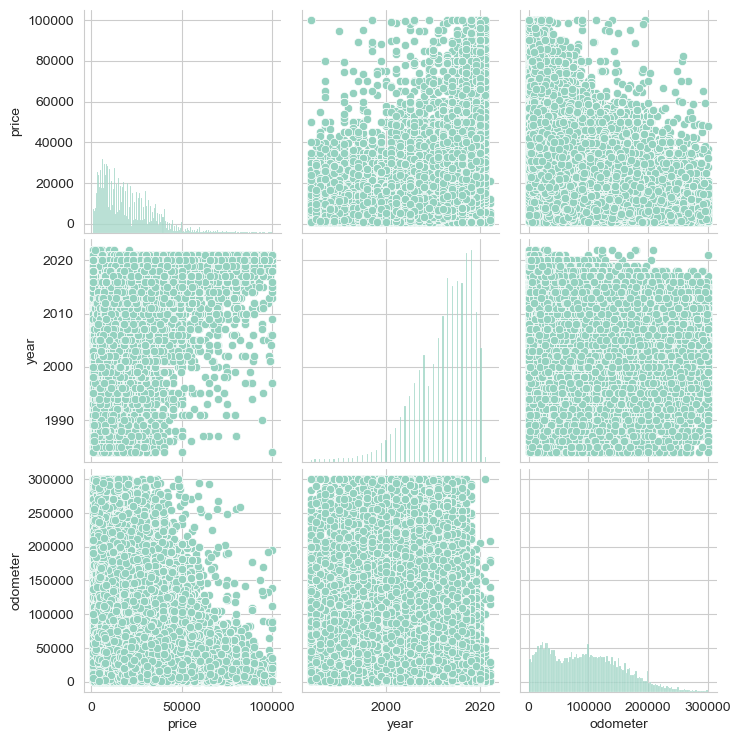

In [152]:
sns.pairplot(vehicles)

/var/folders/wf/kv9qr5jx1t1f95ygdnp2mqwr0000gp/T/ipykernel_44817/2858094302.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vehicles['price'])


[]

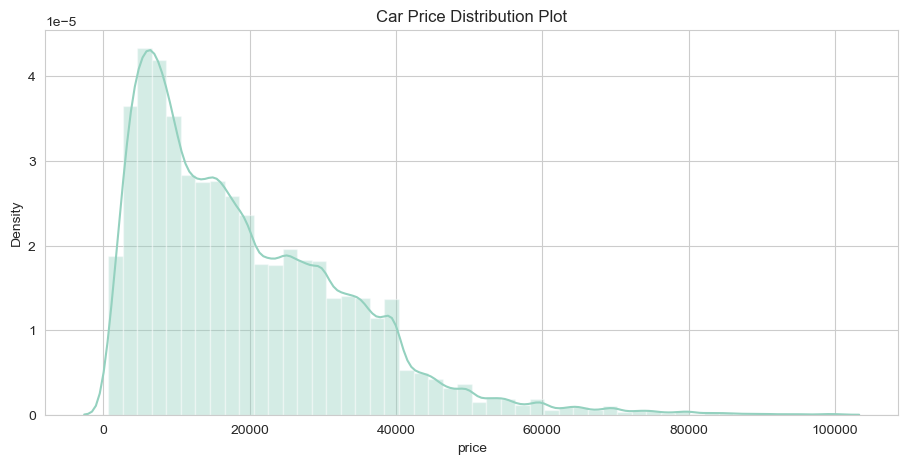

In [153]:
plt.figure(figsize=[11, 5])
sns.distplot(vehicles['price'])
plt.title('Car Price Distribution Plot')
plt.plot()

/var/folders/wf/kv9qr5jx1t1f95ygdnp2mqwr0000gp/T/ipykernel_44817/1605443737.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vehicles['odometer'])


[]

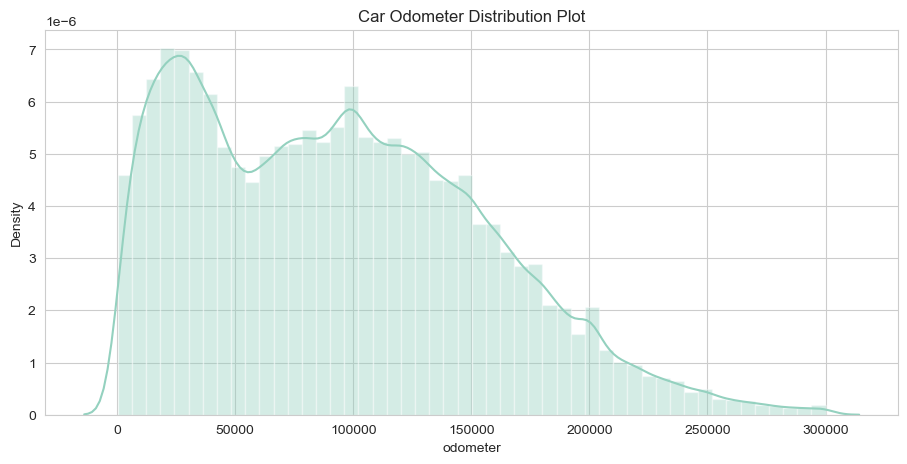

In [154]:
plt.figure(figsize=[11, 5])
sns.distplot(vehicles['odometer'])
plt.title('Car Odometer Distribution Plot')
plt.plot()

[]

<Figure size 1100x500 with 0 Axes>

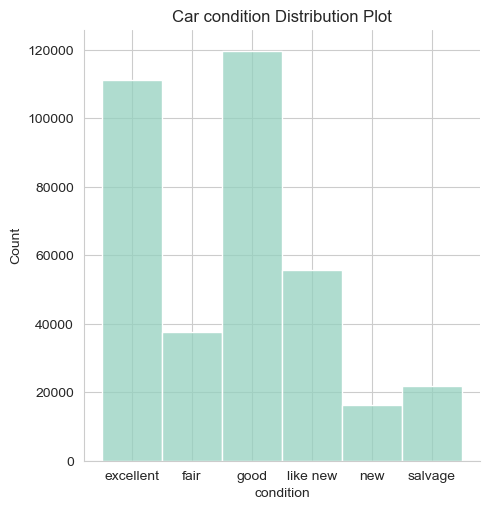

In [155]:
plt.figure(figsize=[11, 5])
sns.displot(vehicles['condition'])
plt.title('Car condition Distribution Plot')
plt.plot()

[]

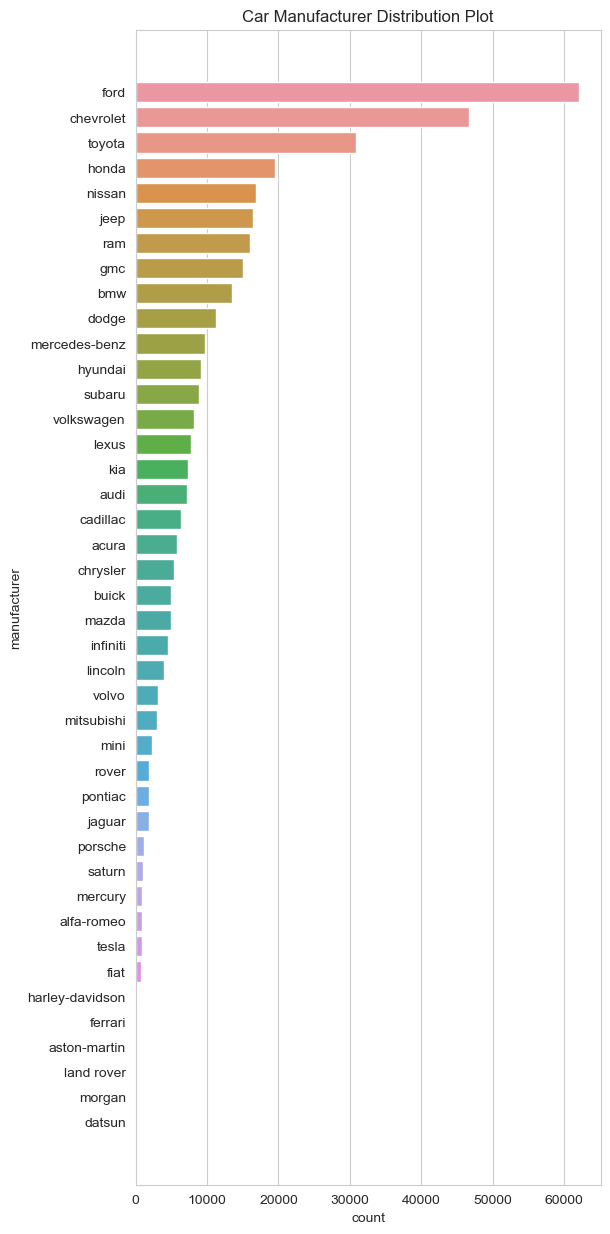

In [156]:
plt.figure(figsize=[6, 15])
sns.countplot(data = vehicles, y = 'manufacturer', order=vehicles['manufacturer'].value_counts().index)
plt.title('Car Manufacturer Distribution Plot')
plt.plot()

<AxesSubplot:xlabel='odometer', ylabel='price'>

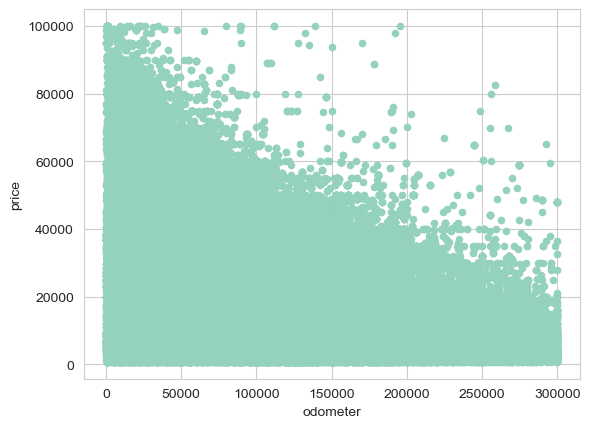

In [157]:
vehicles.plot.scatter(x='odometer', y='price')

[]

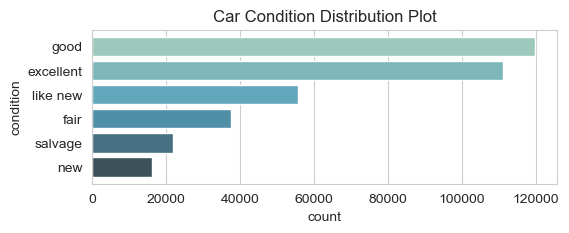

In [158]:
plt.figure(figsize=[6, 2])
sns.countplot(data = vehicles, y = 'condition', order=vehicles['condition'].value_counts().index)
plt.title('Car Condition Distribution Plot')
plt.plot()

[]

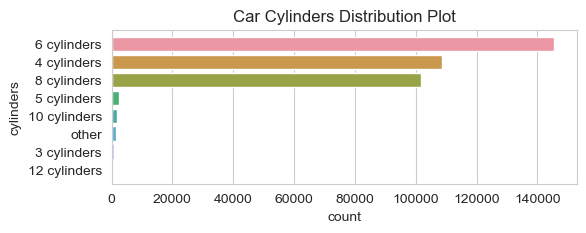

In [159]:
plt.figure(figsize=[6, 2])
sns.countplot(data = vehicles, y = 'cylinders', order=vehicles['cylinders'].value_counts().index)
plt.title('Car Cylinders Distribution Plot')
plt.plot()

In [160]:
list(vehicles)

cleaned_dataset = vehicles.copy()

Convert categorical values to numeric values

In [161]:
le = preprocessing.LabelEncoder()

categorical_cols = ['manufacturer', 'condition','cylinders', 'fuel', 'title_status', 'transmission','drive','size','type','paint_color', 'state']

cleaned_dataset[categorical_cols] = cleaned_dataset[categorical_cols].apply(le.fit_transform)



In [162]:
cleaned_dataset.head(10)

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
31,15000,2013.0,13,0,5,2,128000.0,0,0,2,1,10,0,1
32,27990,2012.0,14,2,6,2,68696.0,0,2,0,1,8,0,1
33,34590,2016.0,7,2,5,2,29499.0,0,2,0,1,8,9,1
34,35000,2019.0,39,0,5,2,43000.0,0,0,0,1,10,5,1
35,29990,2016.0,7,2,5,2,17302.0,0,2,0,1,8,8,1
36,38590,2011.0,7,2,6,2,30237.0,0,2,2,1,7,8,1
37,4500,1992.0,20,0,5,2,192000.0,0,0,0,1,7,8,1
38,32990,2017.0,20,2,5,2,30041.0,0,2,0,1,7,9,1
39,24590,2017.0,7,2,5,2,40784.0,0,2,0,1,8,10,1
40,30990,2016.0,7,2,5,4,34940.0,0,2,0,1,8,1,1


# Linear Regression

In [163]:
y = cleaned_dataset.price
X = cleaned_dataset.drop('price', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(289700, 13) (289700,)
(72426, 13) (72426,)


In [164]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_predict_lin_reg = lr.predict(X_test)
rmse_lin_reg = np.sqrt(mean_squared_error(y_test, y_predict_lin_reg))

accuracy = lr.score(X_test, y_test)

print(f"RMSE from Linear Regression {rmse_lin_reg}")
print(f"MSE from Linear Regression {mean_squared_error(y_test, y_predict_lin_reg)}")
print(f"MAE from Linear Regression {mean_absolute_error(y_test, y_predict_lin_reg)}")
print(f"accuracy {accuracy*100}")
print(f"intercept: {lr.intercept_}")
print(f"coeff: {lr.coef_}")

RMSE from Linear Regression 9908.094105971484
MSE from Linear Regression 98170328.81278685
MAE from Linear Regression 7237.448349605528
accuracy 51.53707143596598
intercept: -1592680.0191186138
coeff: [ 8.03554222e+02 -3.13850868e+01  6.07062072e+02  2.28945558e+03
 -3.74817819e+03 -8.31036231e-02 -1.46972737e+03  1.06195692e+03
 -1.95123889e+03 -1.34051691e+02  1.04236467e+02  4.94939231e+01
 -1.28053899e+00]


In [165]:
coeff_df = pd.DataFrame(lr.coef_, X.columns, columns=["Coefficient"])
coeff_df

,Coefficient
year,803.554222
manufacturer,-31.385087
condition,607.062072
cylinders,2289.455583
fuel,-3748.178187
odometer,-0.083104
title_status,-1469.727367
transmission,1061.956918
drive,-1951.238886
size,-134.051691


In [166]:
OLS_predict = lr.predict(X_train)
print('Mean Absolute Error:', round(mean_absolute_error(y_train, OLS_predict),2))
print('Mean Squared Error:', round(mean_squared_error(y_train, OLS_predict),2))
print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_train, OLS_predict)),2))

Mean Absolute Error: 7240.32
Mean Squared Error: 98433400.94
Root Mean Squared Error: 9921.36


In [167]:
y_predict = lr.predict(X_test)
df = pd.DataFrame({"Actual": y_test, "Predicted": y_predict})
df.head(20)

,Actual,Predicted
2904,12500,373.519588
68186,12995,-2980.312373
50101,9500,13058.670705
247142,6500,17797.604491
274487,3700,5371.923497
285551,9495,19406.289285
213802,2995,6694.695712
282140,37590,26741.885067
369232,3295,-2390.116387
286793,5995,4333.437646


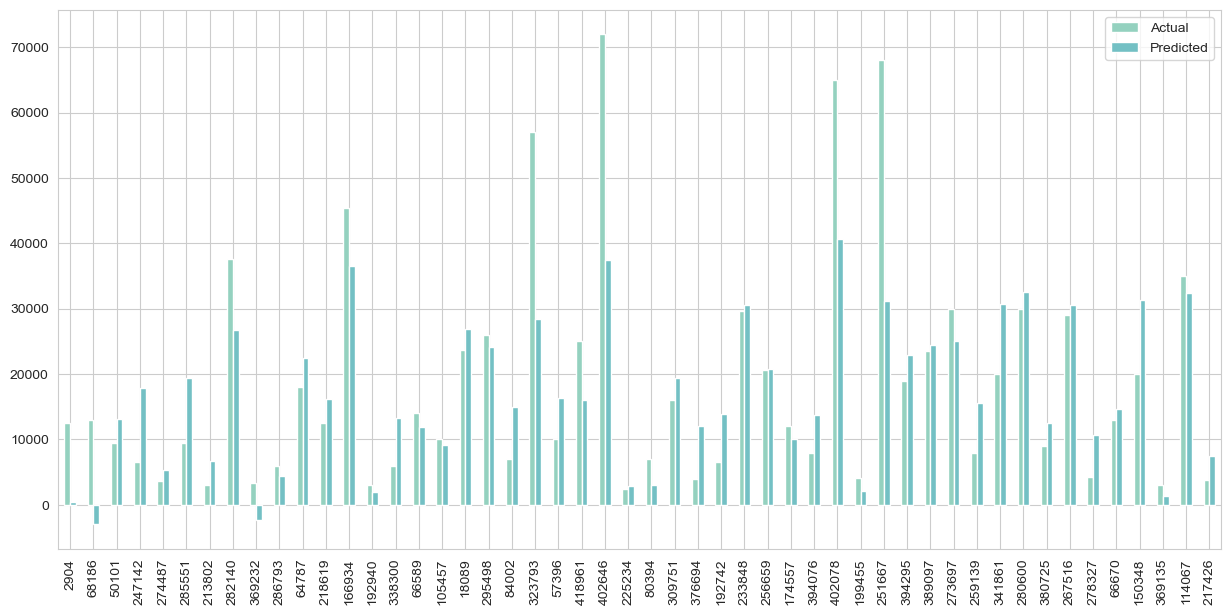

In [168]:
df.head(50).plot(kind="bar", figsize=(15,7))
plt.show()

In [169]:
y_pred = lr.predict(X_test)
print('Mean Absolute Error:', round(mean_absolute_error(y_pred, y_test),2))
print('Mean Squared Error:', round(mean_squared_error(y_pred, y_test),2))
print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_pred, y_test)),2))

Mean Absolute Error: 7237.45
Mean Squared Error: 98170328.81
Root Mean Squared Error: 9908.09


# Random Forest

In [170]:
random_forest_reg = RandomForestRegressor(n_estimators=20, random_state=0)
random_forest_reg.fit(X_train, y_train)
y_predict = random_forest_reg.predict(X_test)


print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_predict),2))
print('Mean Squared Error:', round(mean_squared_error(y_test, y_predict),2))
print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_predict)),2))

Mean Absolute Error: 3073.74
Mean Squared Error: 31221881.16
Root Mean Squared Error: 5587.65


Let's change the estimator to 100

In [171]:
random_forest_reg = RandomForestRegressor(n_estimators=100, random_state=0)
random_forest_reg.fit(X_train, y_train)
y_predict = random_forest_reg.predict(X_test)


print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_predict),2))
print('Mean Squared Error:', round(mean_squared_error(y_test, y_predict),2))
print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_predict)),2))

Mean Absolute Error: 2976.18
Mean Squared Error: 29825503.52
Root Mean Squared Error: 5461.27


In [172]:
random_forest_reg = RandomForestRegressor(n_estimators=200, random_state=0)
random_forest_reg.fit(X_train, y_train)
y_predict = random_forest_reg.predict(X_test)


print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_predict),2))
print('Mean Squared Error:', round(mean_squared_error(y_test, y_predict),2))
print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_predict)),2))

Mean Absolute Error: 2961.59
Mean Squared Error: 29634253.91
Root Mean Squared Error: 5443.74


# Feature importance in RandomForest

In [173]:
importances = list(random_forest_reg.feature_importances_)
importances

[0.44234234095093333,
 0.0707945526177048,
 0.022695245926357667,
 0.04556342777887107,
 0.1087664610132733,
 0.14142470595847578,
 0.0066591758566253365,
 0.01276802393476804,
 0.044079028568436256,
 0.010102268866068596,
 0.0402870166575334,
 0.02063605444632823,
 0.0338816974246242]

In [174]:
list(cleaned_dataset)

['price',
 'year',
 'manufacturer',
 'condition',
 'cylinders',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color',
 'state']

In [175]:
feature_list = cleaned_dataset.drop('price', axis=1).columns
feature_importance = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances) ]
feature_importance = sorted(feature_importance, key = lambda x: x[1], reverse=True)
[print ("Feature: {:20}      Importance: {}".format(*pair)) for pair in feature_importance]

Feature: year                      Importance: 0.442
Feature: odometer                  Importance: 0.141
Feature: fuel                      Importance: 0.109
Feature: manufacturer              Importance: 0.071
Feature: cylinders                 Importance: 0.046
Feature: drive                     Importance: 0.044
Feature: type                      Importance: 0.04
Feature: state                     Importance: 0.034
Feature: condition                 Importance: 0.023
Feature: paint_color               Importance: 0.021
Feature: transmission              Importance: 0.013
Feature: size                      Importance: 0.01
Feature: title_status              Importance: 0.007


[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [176]:
random_forest_importance_df = pd.DataFrame(feature_importance, columns=["Feature", "Importance"])

<AxesSubplot:xlabel='Feature'>

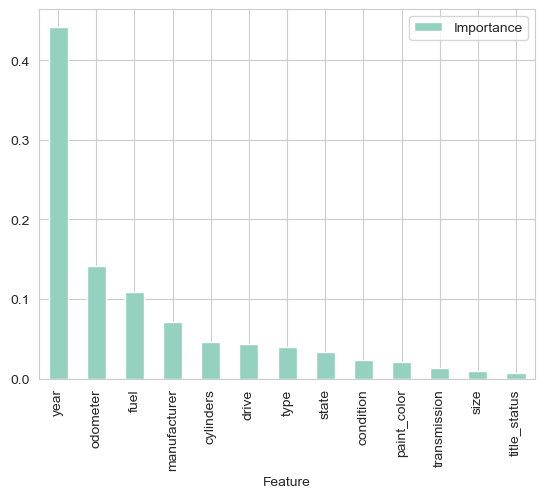

In [177]:
random_forest_importance_df.plot(kind="bar", x="Feature", y="Importance")

In [178]:
y_predict = random_forest_reg.predict(X_test)
df = pd.DataFrame({"Actual": y_test, "Predicted": y_predict})
df.head(20)

,Actual,Predicted
2904,12500,11677.380000
68186,12995,12995.000000
50101,9500,9329.251750
247142,6500,10860.230000
274487,3700,3475.551667
285551,9495,11438.030000
213802,2995,4127.644464
282140,37590,35694.300000
369232,3295,3044.590000
286793,5995,5576.500000


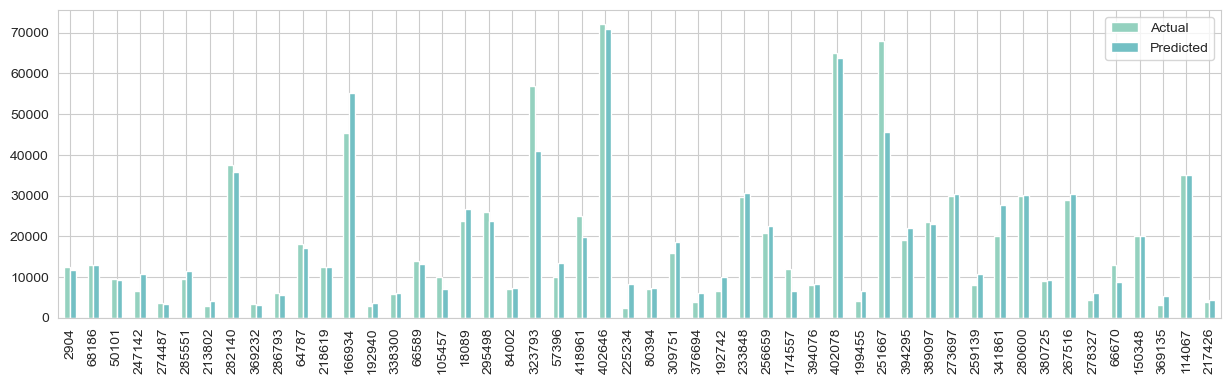

In [179]:
df.head(50).plot(kind="bar", figsize=(15,4))
plt.show()

# Ridge Regression

In [180]:
alphas = 10**np.linspace(start=10, stop=-3, num=100) * 0.5
alphas

array([5.00000000e+09, 3.69536102e+09, 2.73113861e+09, 2.01850863e+09,
       1.49182362e+09, 1.10256537e+09, 8.14875417e+08, 6.02251770e+08,
       4.45107543e+08, 3.28966612e+08, 2.43130079e+08, 1.79690683e+08,
       1.32804389e+08, 9.81520325e+07, 7.25414389e+07, 5.36133611e+07,
       3.96241449e+07, 2.92851041e+07, 2.16438064e+07, 1.59963357e+07,
       1.18224471e+07, 8.73764200e+06, 6.45774833e+06, 4.77274228e+06,
       3.52740116e+06, 2.60700414e+06, 1.92676430e+06, 1.42401793e+06,
       1.05245207e+06, 7.77838072e+05, 5.74878498e+05, 4.24876718e+05,
       3.14014572e+05, 2.32079442e+05, 1.71523464e+05, 1.26768225e+05,
       9.36908711e+04, 6.92443186e+04, 5.11765511e+04, 3.78231664e+04,
       2.79540509e+04, 2.06600620e+04, 1.52692775e+04, 1.12850986e+04,
       8.34050269e+03, 6.16423370e+03, 4.55581378e+03, 3.36707533e+03,
       2.48851178e+03, 1.83918989e+03, 1.35929412e+03, 1.00461650e+03,
       7.42484131e+02, 5.48749383e+02, 4.05565415e+02, 2.99742125e+02,
      

Text(0, 0.5, 'weights')

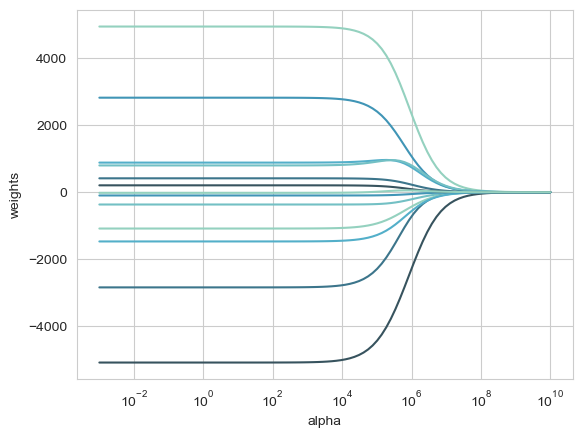

In [181]:
from sklearn.preprocessing import scale 
ridge = Ridge()
coeffs = []

for alpha in alphas:
    ridge.set_params(alpha=alpha)
    ridge.fit(scale(X_train), y_train)
    coeffs.append(ridge.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coeffs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
    

In [182]:
# use cross validation to find the right alpha value to use for model tuning
from sklearn.linear_model import RidgeCV

ridgecv = RidgeCV(alphas = alphas, scoring='neg_mean_squared_error', normalize=True)

ridgecv.fit(X_train, y_train)

ridgecv.alpha_


0.0005

In [183]:
pred = ridgecv.predict(X_test)

print(pd.Series(ridgecv.coef_, index = X.columns))


year             803.300759
manufacturer     -31.383675
condition        607.287369
cylinders       2288.319035
fuel           -3745.689005
odometer          -0.083066
title_status   -1469.023241
transmission    1062.633286
drive          -1950.411292
size            -134.042845
type             104.220177
paint_color       49.481146
state             -1.272302
dtype: float64


In [184]:

print('Mean Absolute Error:', round(mean_absolute_error(y_test, pred),2))
print('Mean Squared Error:', round(mean_squared_error(y_test, pred),2))
print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, pred)),2))
     


Mean Absolute Error: 7237.39
Mean Squared Error: 98171043.34
Root Mean Squared Error: 9908.13


<AxesSubplot:title={'center':'Feature importance using Ridge model'}>

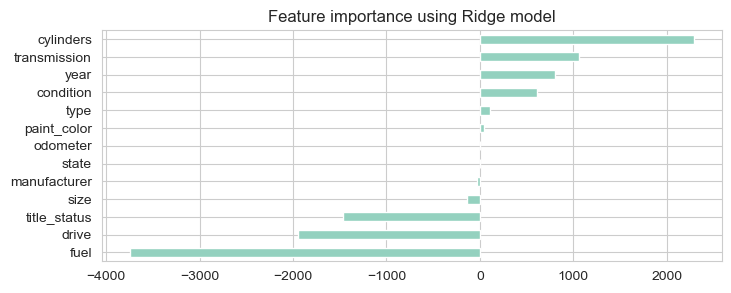

In [185]:

coef_ridge= pd.Series(ridgecv.coef_, index = X.columns)

important_coef = coef_ridge.sort_values()

important_coef.plot(kind="barh" , title="Feature importance using Ridge model", figsize=(8, 3))


# Lasso Model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


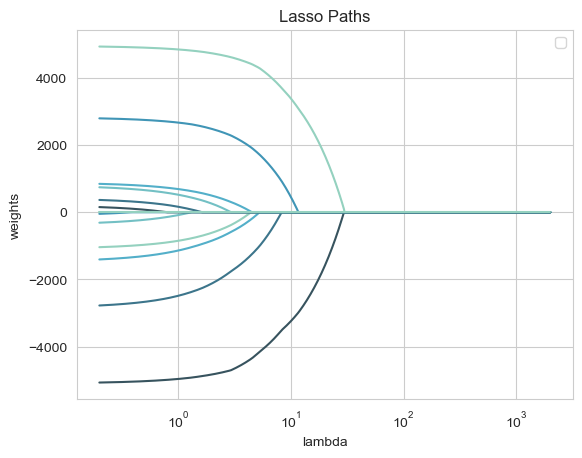

In [186]:
lasso = Lasso(alpha=1.0, normalize = True, max_iter=10000)

coefficients = []
alphas = np.logspace(-1, 3, 1000)

for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(scale(X_train), y_train)
    coefficients.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefficients)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('Lasso Paths')
plt.legend()
     


In [187]:
lasso_reg = LassoCV(alphas=None, cv=10, normalize=True, max_iter=10000)
lasso_reg.fit(X_train, y_train)

print(f"Best Alpha using LassoCV {lasso_reg.alpha_}")
print(f"Best Score using LassoCV {lasso_reg.score(X_train, y_train)}")
print(f"Root Mean Squared Error using LassoCV {np.sqrt(mean_squared_error(y_test, lasso_reg.predict(X_test)))}")



Best Alpha using LassoCV 0.014959897255340877
Best Score using LassoCV 0.5090279559644144
Root Mean Squared Error using LassoCV 9908.313909401491


In [188]:
y_pred_lasso = lasso_reg.predict(X_test)

In [189]:
print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred_lasso),2))
print('Mean Squared Error:', round(mean_squared_error(y_test, y_pred_lasso),2))
print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred_lasso)),2))
     


Mean Absolute Error: 7237.72
Mean Squared Error: 98174684.53
Root Mean Squared Error: 9908.31


In [190]:
coefficients = pd.Series(lasso_reg.coef_, index = X.columns)

<AxesSubplot:title={'center':'Feature importance using Lasso model'}>

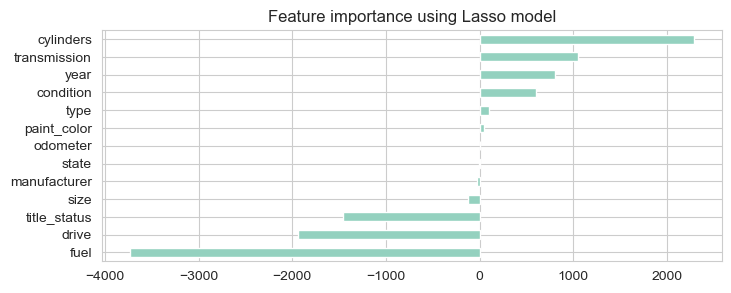

In [191]:
coef_lasso= pd.Series(lasso_reg.coef_, index = X.columns)

important_coef = coef_lasso.sort_values()

important_coef.plot(kind="barh" , title="Feature importance using Lasso model", figsize=(8, 3))
